In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/train.csv
/kaggle/input/dataset/test.csv


In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from transformers import TFBertModel

from imblearn.over_sampling import SMOTE
from imblearn.combine import *
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import keras
import os
import re 

In [3]:
def preprocess(text):
  
  text=text.lower()
  text=re.sub(r'rt\s*@[^:]*:\s', ' ', text)
  text=re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text=re.sub(r' t .*$', '', text)
  text=re.sub(r'\b[a-zA-Z]\b', '', text)
  text=re.sub(r'/^\s+|\s+$|\s+(?=\s)/g', '', text);
  text = re.sub(r's+[a-zA-Z]s+', '', text)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text=re.sub(r'https?','',text)
  text=re.sub(r'#[A-Za-z0-9_]+','',text)
  text=re.sub(r'\.\.\.',' ',text)
  text=text.replace('…',' ')
  text=text.replace('..',' ')
  text=re.sub(r'@\w*',r'',text)
  text=re.sub(r'\s{2,}',r' ',text)
  text=re.sub(r'$[\s]+','',text)
  text=text.replace('&amp','')
  text=text.replace('&gt','')
  text=text.replace('&lt','')
  text=re.sub(r'([\w\d]+)([^\w\d ]+)', r'\1 \2',text)
  text=re.sub(r'([^\w\d ]+)([\w\d]+)', r'\1 \2',text)
 
  return text

In [4]:
train = pd.read_csv('/kaggle/input/dataset/train.csv', index_col = 0)
del(train["tweet_id"])
del(train["image_id"])
del(train["image_path"])
del(train["text_info_conf"])
del(train["image_info"])
del(train["image_info_conf"])
del(train["text_human"])
del(train["text_human_conf"])
del(train["image_human"])
del(train["image_human_conf"])
del(train["image_damage"])
del(train["image_damage_conf"])
del(train["image_url"])
del(train["Unnamed: 0.1"])

train["tweet_text"]=train["tweet_text"].apply(lambda x: preprocess(x))
train["type"] = train["text_info"].apply(lambda x: 1 if x == "informative"  else 0)

train

,text_info,tweet_text,type
15380,informative,irma creates bittersweet travel bonus for luck...,1
12344,informative,hurricane irma orange county mayor jacobs str...,1
15867,informative,tax help for busine hit by harvey and irma can...,1
9291,informative,miranda lambert amp chris stapleton to join ge...,1
10180,not_informative,hurricane blame harvey amp irma punishment for...,0
...,...,...,...
10536,informative,list of the greatest storms harvey irma katri...,1
7227,informative,more photos earthquake at kurdistan photos be...,1
13854,informative,money irma cnnpolitics republicans aren,1
8948,not_informative,you can spot my short ass behind all the trash...,0


In [5]:
test = pd.read_csv('/kaggle/input/dataset/test.csv', index_col = 0)
del(test["tweet_id"])
del(test["image_id"])
del(test["image_path"])
del(test["text_info_conf"])
del(test["image_info"])
del(test["image_info_conf"])
del(test["text_human"])
del(test["text_human_conf"])
del(test["image_human"])
del(test["image_human_conf"])
del(test["image_damage"])
del(test["image_damage_conf"])
del(test["image_url"])
del(test["Unnamed: 0.1"])

test["tweet_text"]=test["tweet_text"].apply(lambda x: preprocess(x))
test["type"] = test["text_info"].apply(lambda x: 1 if x == "informative"  else 0)

test 

,text_info,tweet_text,type
586,not_informative,incredible moment family dog emerges unscathed...,0
5116,informative,it may be dark in puerto rico but electric cus...,1
4549,not_informative,comic diary about what we re living in puertor...,0
15254,not_informative,enjoy your first night after irma with no curfew,0
1691,informative,bangladesh has evacuated at least 350 000 peo...,1
...,...,...,...
17618,informative,4 00 magnitude earthquake has occurred near o...,1
8818,informative,some of texas most selfless hurricane harvey h...,1
12462,informative,irma destruction island by island,1
11417,not_informative,making difference back in my hometown hurrican...,0


In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-05-08 16:31:05.307553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 16:31:05.308765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 16:31:05.309483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 16:31:05.310370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
tokenized_train = train["tweet_text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_test = test["tweet_text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [8]:
labels_train = train["type"].values
labels_test = test["type"].values

In [9]:
max_len = 0

for i in tokenized_train.values:
  if len(i) > max_len:
    max_len = len(i)
    
max_len

42

In [10]:
input_ids_train= np.array([i + [0]*(max_len-len(i)) for i in tokenized_train.values])
input_ids_test= np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])

In [11]:
smt = SMOTE(sampling_strategy='minority')
input_ids_train, labels_train = smt.fit_resample(input_ids_train, labels_train)

In [12]:
attention_mask_train= np.where(input_ids_train!= 0, 1, 0)
attention_mask_test= np.where(input_ids_test!= 0, 1, 0)

In [13]:
dataset_train = tf.data.Dataset.from_tensor_slices((input_ids_train,attention_mask_train,labels_train))
dataset_test = tf.data.Dataset.from_tensor_slices((input_ids_test,attention_mask_test,labels_test))

def map_func(input_ids, masks, labels):
    return {'input_ids' : input_ids, 'attention_mask' : masks}, labels

dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

In [14]:
dataset_train = dataset_train.shuffle(4800)

dataset_train = dataset_train.batch(128)
dataset_test = dataset_test.batch(32)

In [15]:
input_ids = tf.keras.layers.Input(shape=(max_len,), name = "input_ids", dtype = 'int32')
mask = tf.keras.layers.Input(shape=(max_len,), name = "attention_mask", dtype = 'int32')

embeddings = bert.bert(input_ids, attention_mask=mask)
#pooled = embeddings[1]
hidden_layers = embeddings[2]

sum_layer1 = hidden_layers[-4]
sum_layer2 = hidden_layers[-3]
sum_layer3 = hidden_layers[-2]
sum_layer4 = hidden_layers[-1]

added = tf.keras.layers.Add()([sum_layer1, sum_layer2, sum_layer3, sum_layer4])

lstm = tf.keras.layers.GRU(512, return_sequences=True)(added)
lstm = tf.keras.layers.Dropout(0.2)(lstm)
lstm = tf.keras.layers.GRU(512)(lstm)
lstm = tf.keras.layers.Dropout(0.2)(lstm)
lstm = tf.keras.layers.Dense(256)(lstm)

y = tf.keras.layers.Dense(1, activation="sigmoid", name="outputs")(lstm)

In [16]:
model = tf.keras.Model(inputs = [input_ids, mask], outputs = [y])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 42)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 42)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
add (Add)                       (None, 42, 768)      0           bert[0][9]                   

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, decay = 0.01)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = METRICS = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)  
mc = keras.callbacks.ModelCheckpoint('/kaggle/working/BERT_best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose =1)

model.compile(optimizer=optimizer, loss = loss, metrics = metrics)

In [18]:
history = model.fit(
    dataset_train,
    validation_data = dataset_test,
    epochs = 50,
    callbacks=[es, mc]
)

Epoch 1/50


2022-05-08 16:31:53.013854: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-08 16:31:58.295227: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


161/161 [==============================] - 129s 684ms/step - loss: 0.3654 - accuracy: 0.8321 - precison: 0.7945 - recall: 0.8959 - val_loss: 0.4328 - val_accuracy: 0.8134 - val_precison: 0.8572 - val_recall: 0.8849

Epoch 00001: val_loss improved from inf to 0.43281, saving model to /kaggle/working/BERT_best_model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
161/161 [==============================] - 106s 660ms/step - loss: 0.2961 - accuracy: 0.8721 - precison: 0.8533 - recall: 0.8988 - val_loss: 0.4154 - val_accuracy: 0.8220 - val_precison: 0.8645 - val_recall: 0.8888

Epoch 00002: val_loss improved from 0.43281 to 0.41536, saving model to /kaggle/working/BERT_best_model.h5
Epoch 3/50
161/161 [==============================] - 106s 659ms/step - loss: 0.2772 - accuracy: 0.8802 - precison: 0.8631 - recall: 0.9036 - val_loss: 0.4065 - val_accuracy: 0.8275 - val_precison: 0.8549 - val_recall: 0.9121

Epoch 00003: val_loss improved from 0.41536 to 0.40647, saving model to /kaggle/working/BERT_best_model.h5
Epoch 4/50
161/161 [==============================] - 107s 661ms/step - loss: 0.2663 - accuracy: 0.8866 - precison: 0.8691 - recall: 0.9102 - val_loss: 0.4003 - val_accuracy: 0.8291 - val_precison: 0.8623 - val_recall: 0.9039

Epoch 00004: val_loss improved from 0.40647 to 0.40029, saving model to /kaggle/working/BERT_best_model.h

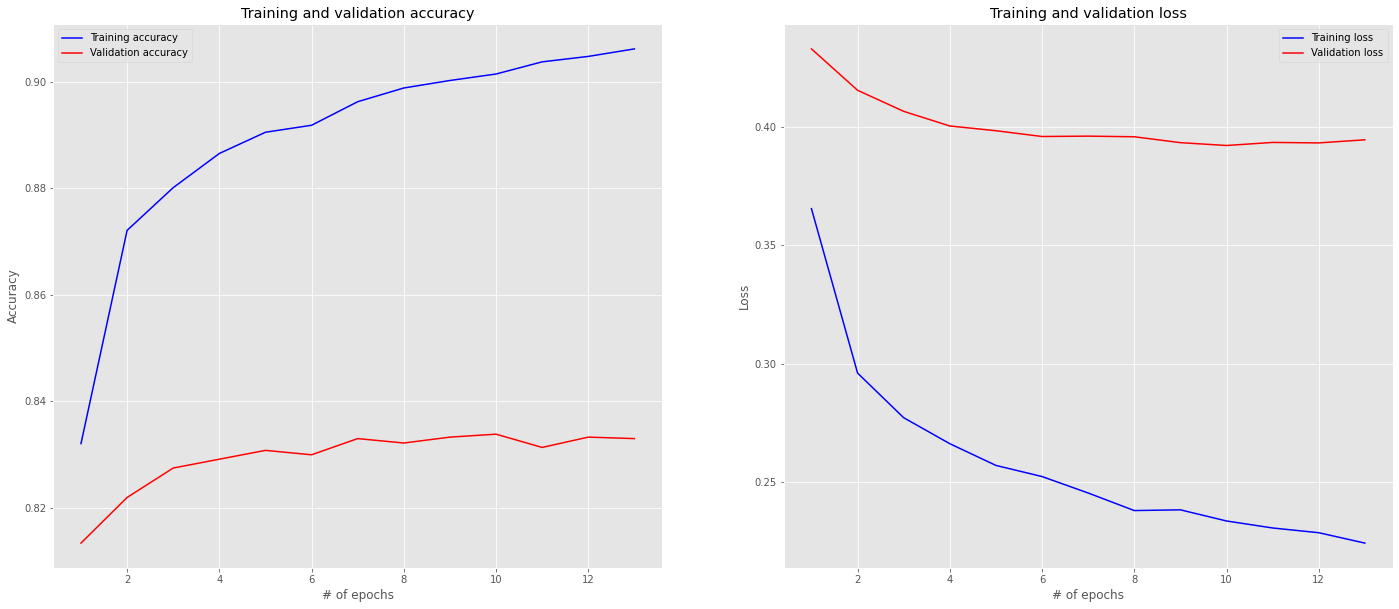

In [19]:
plt.style.use('ggplot')

def plot_history(model):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('# of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('# of epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_history(model)

In [22]:
y_pred = model.predict(dataset_test)

y_pred_hot = []
for i in range(len(y_pred)):
  if (y_pred[i] < 0.5):
    y_pred_hot.append(0)
  else:
    y_pred_hot.append(1)

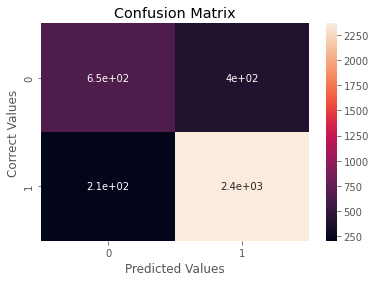


              precision    recall  f1-score   support

           0       0.76      0.62      0.68      1046
           1       0.86      0.92      0.89      2571

    accuracy                           0.83      3617
   macro avg       0.81      0.77      0.78      3617
weighted avg       0.83      0.83      0.83      3617



In [23]:
cm = confusion_matrix(labels_test, y_pred_hot)
cr = classification_report(labels_test, y_pred_hot)

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Correct Values')
plt.xlabel('Predicted Values')
plt.show()
print()
print(cr)